## Long-Term Overnight and Intraday Liquidity Analysis

---




The empirical results of this study affirm a well-established distinction between overnight and intraday market dynamics. In line with theoretical expectations and existing literature, the 20-day rolling volatility and liquidity proxies indicate that overnight periods are characterized by lower liquidity, heightened sensitivity to macroeconomic and firm-specific information, and greater volatility during crisis periods.

Notably, overnight volatility exhibited sharp spikes during global events such as the 2008 financial crisis and the COVID-19 shock, particularly in European and emerging market indices, suggesting a vulnerability to price jumps in the absence of continuous trading. In contrast, intraday volatility, while generally higher in magnitude, was more stable and synchronized across indices, reflecting greater liquidity depth and more efficient price discovery during regular trading hours.

These findings lend empirical support to the view that overnight returns are more susceptible to temporary mispricings—arising from lower trading activity and reduced arbitrage—which are subsequently corrected during intraday trading when liquidity improves and information is more fully incorporated into prices. This distinction is particularly pronounced in emerging markets, where overnight market frictions appear more severe.

This observed behavior of overnight returns also sheds light on the role of overnight gaps as a reflection of underlying liquidity conditions suggesting that overnight gaps are both a signal and a consequence of illiquid market conditions

In [ ]:

# Yahoo Finance
import yfinance as yf

# Core Libraries
import pytz
from datetime import datetime

# Data and Math
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import Javascript

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


In [ ]:

indices = ['^GSPC', '^IXIC', '^DJI', '^FTSE', '^FCHI', '^GDAXI', '^NSEI', '^BSESN']
start = '2004-01-01'
end = '2024-04-30'

# Download data
data = yf.download(tickers=indices, start=start, end=end, group_by='ticker', auto_adjust=False, progress=False)
data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]

# Timezone map (Exchange local close time)
timezone_map = {
    '^GSPC': 'America/New_York',
    '^IXIC': 'America/New_York',
    '^DJI': 'America/New_York',
    '^FTSE': 'Europe/London',
    '^FCHI': 'Europe/Paris',
    '^GDAXI': 'Europe/Berlin',
    '^NSEI': 'Asia/Kolkata',
    '^BSESN': 'Asia/Kolkata'
}

# Process and align all dates to UTC
data_dict = {}

for symbol in indices:
    sub_df = data[[col for col in data.columns if col.startswith(symbol)]].copy()
    sub_df.columns = [col.split('_')[1] for col in sub_df.columns]
    sub_df['Symbol'] = symbol

    # Set local timezone (close of market)
    local_tz = pytz.timezone(timezone_map[symbol])
    local_dt_index = pd.to_datetime(sub_df.index).tz_localize(local_tz, ambiguous='NaT', nonexistent='NaT')

    # Convert to UTC
    utc_index = local_dt_index.tz_convert(pytz.utc)
    sub_df.index = utc_index

    # Drop missing open/close
    sub_df = sub_df[sub_df['Open'].notna() & sub_df['Close'].notna()]
    data_dict[symbol] = sub_df


In [ ]:

results = []

for symbol, df in data_dict.items():
    df['overnight_ret'] = np.log(df['Open'] / df['Close'].shift(1))
    df['intraday_ret'] = np.log(df['Close'] / df['Open'])
    df['amihud'] = np.abs(df['intraday_ret']) / df['Volume']
    df['intraday_vol'] = (df['High'] - df['Low']) / df['Open']

    df['overnight_vol'] = df['overnight_ret'].rolling(20).std()
    df['amihud_liquidity'] = df['amihud'].rolling(20).mean()
    df['intraday_volatility'] = df['intraday_vol'].rolling(20).mean()

    df['Date'] = df.index
    results.append(df[['Date', 'Symbol', 'overnight_vol', 'amihud_liquidity', 'intraday_volatility']])



In [ ]:

df_combined = pd.concat(results)


 a. Overnight Liquidity (Volatility)

**20-Day Rolling Overnight Volatility (Liquidity Proxy)**

**Plot Description**:

* This plot shows the **20-day rolling standard deviation of overnight returns** for several global indices.
* Overnight return = $\log(\text{Open}_t / \text{Close}_{t-1})$

**Interpretation**:

* **Purpose**: This serves as a proxy for **overnight liquidity risk**—higher volatility may imply lower liquidity.
  * When liquidity is deep, large trades or information shocks are absorbed without big price moves.

  * But illiquid markets react more drastically to news or anticipated order flows — hence, larger overnight jumps.

  So, high overnight volatility = high sensitivity to information = low liquidity.




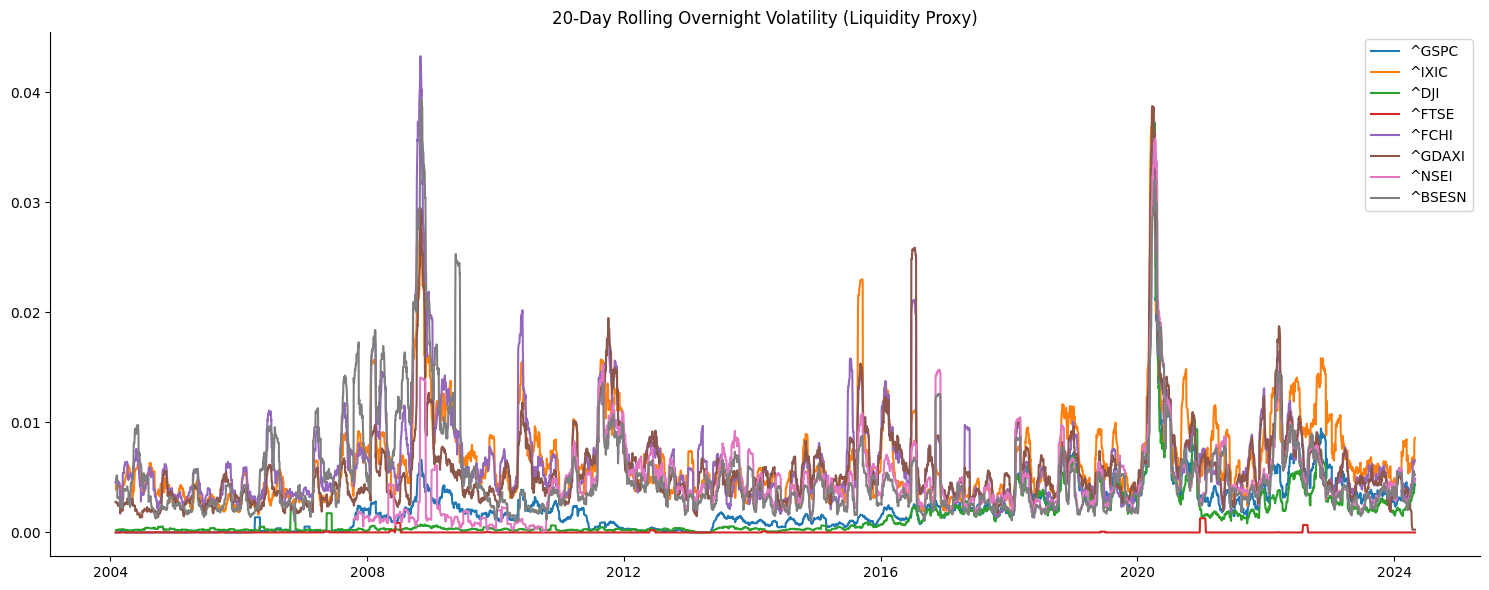

In [ ]:

plt.figure(figsize=(15, 6))

for symbol in indices:
    subset = df_combined[df_combined['Symbol'] == symbol]
    plt.plot(subset['Date'], subset['overnight_vol'], label=symbol)

plt.title("20-Day Rolling Overnight Volatility (Liquidity Proxy)")
plt.legend()

# Remove grid lines
plt.grid(False)

# Keep only bottom and left spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.tight_layout()
plt.show()


b. Intraday Liquidity: Amihud Illiquidity



**20-Day Rolling Amihud Illiquidity (Intraday Liquidity Proxy)**

**Plot Description**:

* This shows the **Amihud illiquidity measure** over a 20-day rolling window:

  $$
  \text{Amihud} = \frac{|\text{Intraday Return}|}{\text{Volume}}
  $$
* Higher values = lower liquidity (larger price movement per unit of volume).


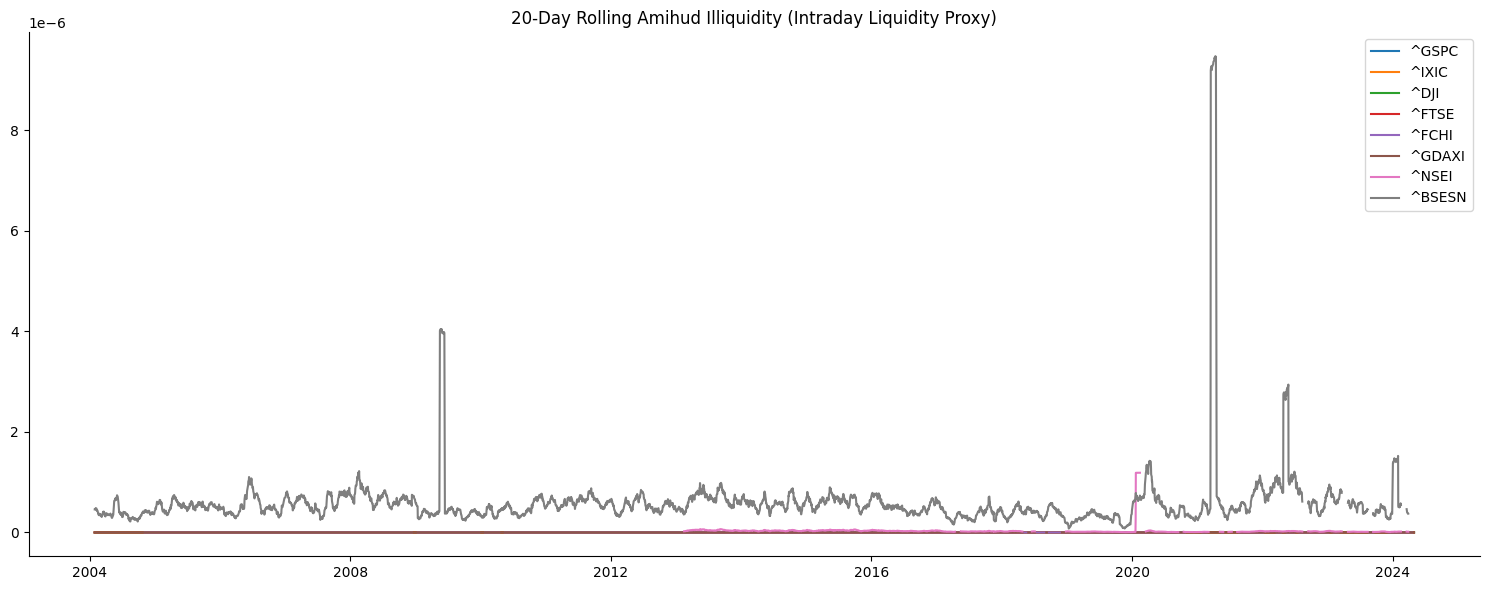

In [ ]:

plt.figure(figsize=(15, 6))

for symbol in indices:
    subset = df_combined[df_combined['Symbol'] == symbol]
    plt.plot(subset['Date'], subset['amihud_liquidity'], label=symbol)

plt.title("20-Day Rolling Amihud Illiquidity (Intraday Liquidity Proxy)")
plt.legend()

# Remove grid lines
plt.grid(False)

# Keep only bottom and left spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.tight_layout()
plt.show()


c. Intraday Liquidity: Volatility

**20-Day Rolling Intraday Volatility**

**Plot Description**:

* Based on intraday range: $(\text{High} - \text{Low}) / \text{Open}$
* Smoothed with a 20-day rolling mean.




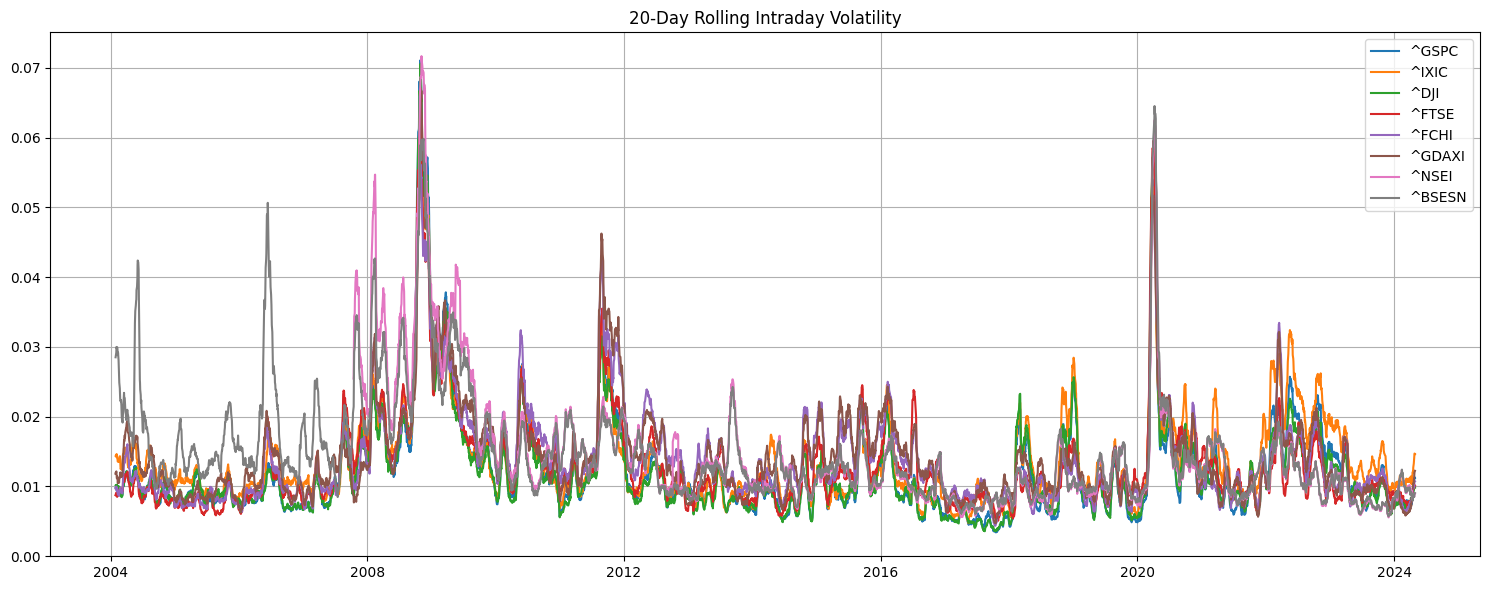

In [ ]:
plt.figure(figsize=(15, 6))

for symbol in indices:
    subset = df_combined[df_combined['Symbol'] == symbol]
    plt.plot(subset['Date'], subset['intraday_volatility'], label=symbol)

plt.title("20-Day Rolling Intraday Volatility")
plt.legend()

# Remove grid lines
plt.grid(False)

# Keep only bottom and left spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.tight_layout()
plt.show()


Visualize each index separately (includes the shaded crisis periods)

In [ ]:

def plot_single_index(df_combined, symbol):
    fig, axes = plt.subplots(3, 1, figsize=(15, 8), sharex=True)

    df = df_combined[df_combined['Symbol'] == symbol]

    # Plot 1: Overnight Volatility
    axes[0].plot(df['Date'], df['overnight_vol'], label='Overnight Volatility', color='purple')
    axes[0].set_title(f"{symbol} - Overnight Volatility")

    # Plot 2: Amihud Illiquidity
    axes[1].plot(df['Date'], df['amihud_liquidity'], label='Amihud Illiquidity', color='orange')
    axes[1].set_title(f"{symbol} - Amihud Illiquidity")

    # Plot 3: Intraday Volatility
    axes[2].plot(df['Date'], df['intraday_volatility'], label='Intraday Volatility', color='green')
    axes[2].set_title(f"{symbol} - Intraday Volatility")

    # Highlight known crisis periods
    for ax in axes:
        ax.axvspan(pd.Timestamp('2007-10-01'), pd.Timestamp('2009-03-31'), color='red', alpha=0.2, label='2008 Crisis')
        ax.axvspan(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-06-30'), color='blue', alpha=0.2, label='COVID-19')
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()


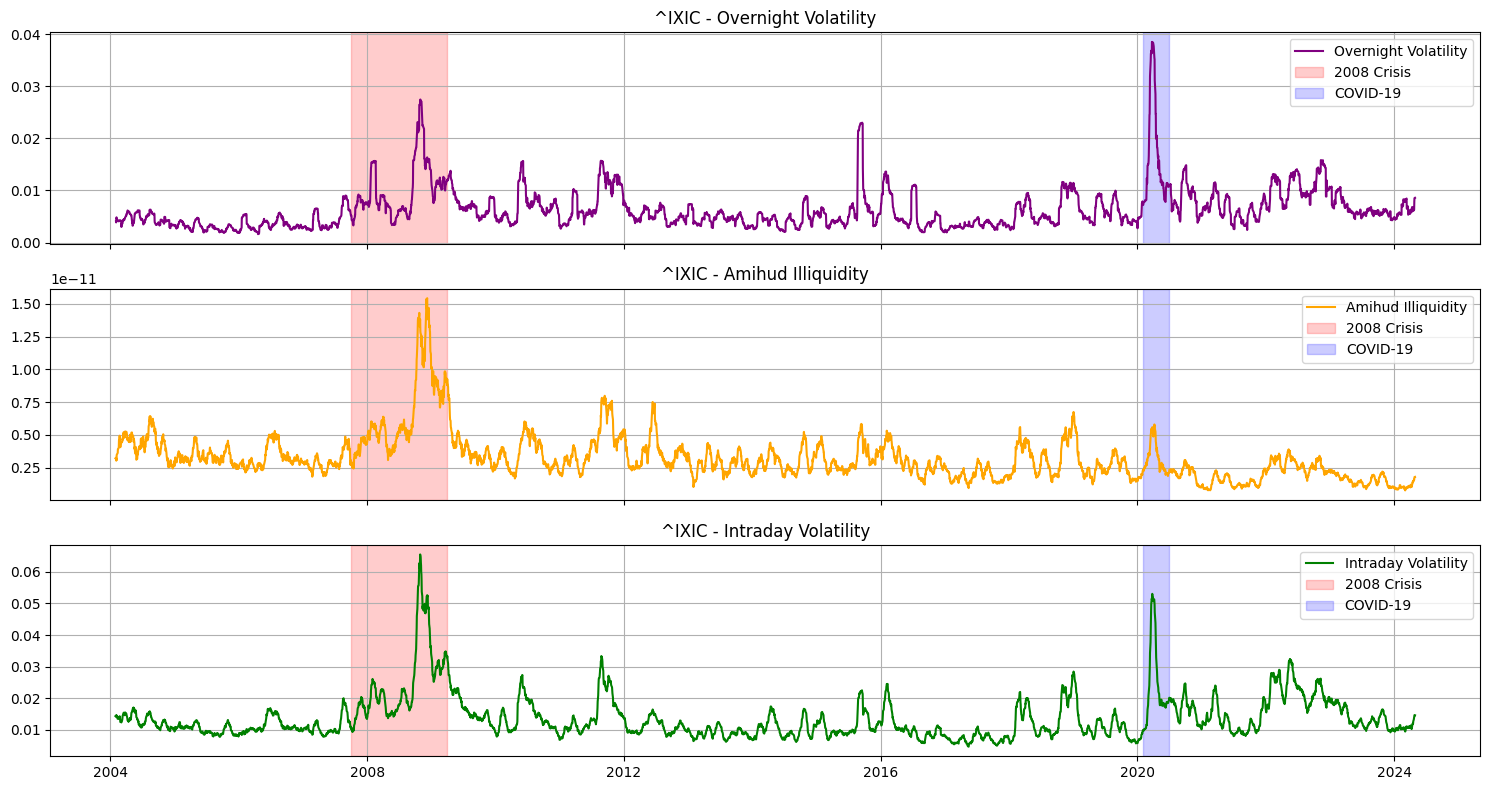

In [ ]:

plot_single_index(df_combined, '^IXIC')



**Volatility ≠ Inverse of Liquidity directly.**


*Overnight volatility is like **a boat rocked by a sudden storm** when no one’s on deck (thin liquidity) while intraday volatility is like **the crew constantly adjusting sails during windy conditions** — there’s motion (volatility), but also people actively managing it (liquidity provision)*.

